In [1]:
# IMPORTING THE REQUIRED LIBRARIES
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

The following sammon function was taken from this Github repo: https://github.com/tompollard/sammon 

In [2]:
# FUNCTION TO IMPLEMENT SAMMON MAPPING
def sammon(x, n, display = 2, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'default'):

    """Perform Sammon mapping on dataset x
    y = sammon(x) applies the Sammon nonlinear mapping procedure on
    multivariate data x, where each row represents a pattern and each column
    represents a feature.  On completion, y contains the corresponding
    co-ordinates of each point on the map.  By default, a two-dimensional
    map is created.  Note if x contains any duplicated rows, SAMMON will
    fail (ungracefully). 
    [y,E] = sammon(x) also returns the value of the cost function in E (i.e.
    the stress of the mapping).
    An N-dimensional output map is generated by y = sammon(x,n) .
    A set of optimisation options can be specified using optional
    arguments, y = sammon(x,n,[OPTS]):
       maxiter        - maximum number of iterations
       tolfun         - relative tolerance on objective function
       maxhalves      - maximum number of step halvings
       input          - {'raw','distance'} if set to 'distance', X is 
                        interpreted as a matrix of pairwise distances.
       display        - 0 to 2. 0 least verbose, 2 max verbose.
       init           - {'pca', 'cmdscale', random', 'default'}
                        default is 'pca' if input is 'raw', 
                        'msdcale' if input is 'distance'
    The default options are retrieved by calling sammon(x) with no
    parameters.
    File        : sammon.py
    Date        : 18 April 2014
    Authors     : Tom J. Pollard (tom.pollard.11@ucl.ac.uk)
                : Ported from MATLAB implementation by 
                  Gavin C. Cawley and Nicola L. C. Talbot
    Description : Simple python implementation of Sammon's non-linear
                  mapping algorithm [1].
    References  : [1] Sammon, John W. Jr., "A Nonlinear Mapping for Data
                  Structure Analysis", IEEE Transactions on Computers,
                  vol. C-18, no. 5, pp 401-409, May 1969.
    Copyright   : (c) Dr Gavin C. Cawley, November 2007.
    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.
    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.
    You should have received a copy of the GNU General Public License
    along with this program; if not, write to the Free Software
    Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA 02111-1307 USA
    """

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        D = x
        if init == 'default':
            init = 'cmdscale'
    else:
        D = cdist(x, x)
        if init == 'default':
            init = 'pca'

    if inputdist == 'distance' and init == 'pca':
        raise ValueError("Cannot use init == 'pca' when inputdist == 'distance'")

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)     

    if np.count_nonzero(D<=0) > 0:
        raise ValueError("Off-diagonal dissimilarities must be strictly positive")   

    Dinv = 1 / D
    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(x)
        y = UU[:,:n]*DD[:n] 
    elif init == 'cmdscale':
        from cmdscale import cmdscale
        y,e = cmdscale(D)
        y = y[:,:n]
    else:
        y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d 
    E = ((delta**2)*Dinv).sum() 

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]

In [3]:
# DATASET PREPARATION
digits = load_digits()
print([i for i in digits.target])

new_X = digits.data
train_y =digits.target

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 4, 6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5, 4, 4, 7, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, 8, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5, 4, 4, 7, 2, 8, 2, 2, 5, 5, 4, 8, 8, 4, 9, 0, 8, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 

In [4]:
# SCALING THE DATASET AND REDUCING DIMENSIONS TO 30 USING PCA
sc = StandardScaler()
new_X_train = sc.fit_transform(new_X)

pca = PCA(n_components = 30)
new_X_train = pca.fit_transform(new_X_train)

print(new_X_train.shape)

(1797, 30)


In [5]:
# TRANSFORMING THE DATASET USING SAMMON MAPPING DIMENSIONALITY REDUCTION

X_sam,E = sammon(new_X_train, 2)

epoch = 1 : E = 0.1577047544
epoch = 2 : E = 0.1563706107
epoch = 3 : E = 0.1563101120
epoch = 4 : E = 0.1551976428
epoch = 5 : E = 0.1545565884
epoch = 6 : E = 0.1527038773
epoch = 7 : E = 0.1514232031
epoch = 8 : E = 0.1512933294
epoch = 9 : E = 0.1511884989
epoch = 10 : E = 0.1495055829
epoch = 11 : E = 0.1493748895
epoch = 12 : E = 0.1491927509
epoch = 13 : E = 0.1439188011
epoch = 14 : E = 0.1438608649
epoch = 15 : E = 0.1407105168
epoch = 16 : E = 0.1381864718
epoch = 17 : E = 0.1374476818
epoch = 18 : E = 0.1358201174
epoch = 19 : E = 0.1339306285
epoch = 20 : E = 0.1329698590
epoch = 21 : E = 0.1325169985
epoch = 22 : E = 0.1319846066
epoch = 23 : E = 0.1319272196
epoch = 24 : E = 0.1319260624
epoch = 25 : E = 0.1314087104
epoch = 26 : E = 0.1312179638
epoch = 27 : E = 0.1278437254
epoch = 28 : E = 0.1275287435
epoch = 29 : E = 0.1274451065
epoch = 30 : E = 0.1267595718
epoch = 31 : E = 0.1266594648
epoch = 32 : E = 0.1266399783
epoch = 33 : E = 0.1255080023
epoch = 34 : E = 0.

In [6]:
# SHAPE OF THE DATASET AFTER SAMMON MAPPING
X_sam.shape

(1797, 2)

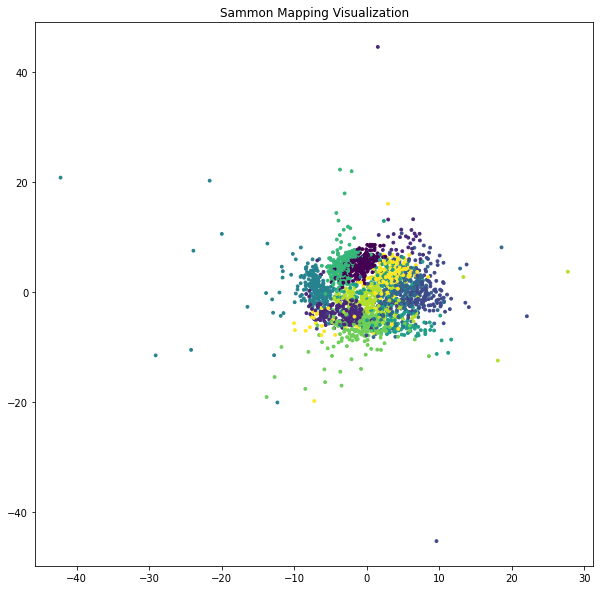

In [8]:
# VISUALIZING THE DATASET RETURNED BY SAMMON MAPPING TECHINIQUE
plt.scatter(X_sam[:, 0], X_sam[:, 1], c=train_y, s=8)
plt.title("Sammon Mapping Visualization")
plt.rcParams['figure.figsize'] = [10, 10]

plt.show()